# Capstone 2: Modeling

### 1. Sourcing and Loading

#### 1a. Import Relevant Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

import warnings
warnings.filterwarnings('ignore')

#### 1b. Load the Data

In [2]:
import hickle as hkl

In [105]:
# load data from file
data = hkl.load(r"...\Capstone2-StrokePrediction\Data\stroke_traintest_data_unscaled2.hkl")

In [106]:
# define individual datasets (previously defined)
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [107]:
# make sure the X data looks correct
X_train.head()

,gender,ever_married,Residence_type,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,id,age,hypertension,heart_disease,avg_glucose_level,bmi
2331,1,1,0,0,0,1,0,0,0,1,0,0,15351,37.0,0,0,91.68,32.4
3901,1,1,1,0,0,1,0,0,0,0,1,0,37479,54.0,0,0,93.96,33.3
1436,1,1,0,1,0,0,0,0,0,1,0,0,71318,67.0,0,0,244.28,29.4
1018,0,1,0,0,0,0,1,0,1,0,0,0,17437,63.0,0,0,85.60,25.9
3567,0,1,0,0,0,0,1,0,0,0,1,0,62475,39.0,1,0,88.18,33.5


In [108]:
# remove ID columns for modeling
X_train_id = X_train['id']
X_train = X_train.drop(['id'], axis=1)

X_test_id = X_test['id']
X_test = X_test.drop(['id'], axis=1)

X_train.columns

Index(['gender', 'ever_married', 'Residence_type', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'age',
       'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'],
      dtype='object')

In [7]:
# make sure the y data is there
y_train.head()

2331    0
3901    0
1436    0
1018    0
3567    0
Name: stroke, dtype: int64

In [8]:
# verify data set shapes
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (4086, 17)
X_test shape: (1022, 17)
y_train shape: (4086,)
y_test shape: (1022,)


### 2. Create Baseline Models

Now, we can select a few algorithms and create baseline models. In these models, we want to keep things fairly simple and strive to select one or two algorithms to move forward with. Once we select the best models, we can do further parameter testing and try to optimize the performance. Speaking of performance, we will look at the ROC curves for the baseline models to determine their performace. Furthermore, reducing false-negative predictions (predicting non-stroke when actually stroke) is very important in healthcare datasets such as these where the predictions could lead to missing a diagnosis. 

The models that will be tested here are a random forest classifier, support vector machine, logistic regression, XGBoost, and CatBoost.

In [101]:
# create arrays to track results
name = []
AUC = []
F1_score = []
Fb_score = []

#### 2a. Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, recall_score, fbeta_score

In [11]:
# create grid search and fit model
params = {'n_estimators':[50, 100, 200, 300], 'max_depth':[3,7,20], 'min_samples_split':[2,4,10]}
rfc = RandomForestClassifier(random_state=42)
rfc_cv = GridSearchCV(rfc, params, scoring='recall', cv=5)
rfc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 7, 20],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='recall')

In [12]:
# print best parameters
print("Best Parameters: " + str(rfc_cv.best_params_))

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


In [110]:
# create model with best parameters
rfc = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_test_proba = rfc.predict_proba(X_test)

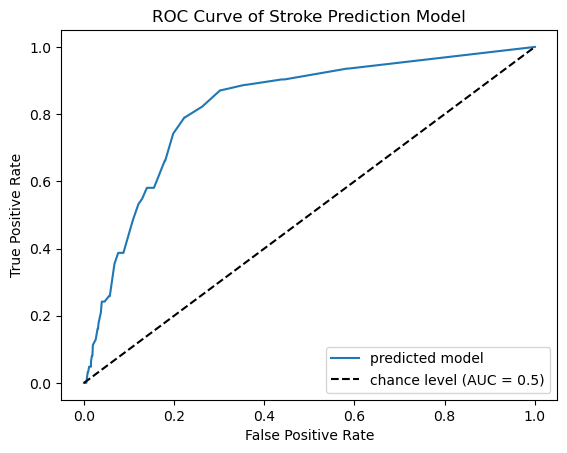

AUC score: 0.8238239247311829


In [111]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [112]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[957,   3],
       [ 62,   0]], dtype=int64)

In [113]:
# populate result arrays
name.append('RandomForest')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))
Fb_score.append(fbeta_score(y_test, np.round(y_test_proba[:,1]), beta=1.5))

As we can see from the ROC curve and the confusion matrix, this classifier did a bad job at distinguishing the classes. This model has zero recall, meaning it predicted all observations to be '0'.

#### 2b. Support Vector Machine

In [17]:
from sklearn.svm import SVC

In [18]:
# create grid search and fit model
params = {'C':[0.1, 1, 10, 100, 1000], 'gamma':['auto'], 'kernel':['rbf']}
svc = SVC(random_state=42)
svc_cv = GridSearchCV(svc, params, scoring='recall', cv=5)
svc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': ['auto'],
                         'kernel': ['rbf']},
             scoring='recall')

In [19]:
# print best parameters
print("Best Parameters: " + str(svc_cv.best_params_))

Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [114]:
# create model with best parameters
svc = SVC(C=10, gamma='auto', kernel='rbf', probability=True, random_state=42)
svc.fit(X_train, y_train)
y_train_pred = svc.predict(X_train)
y_test_proba = svc.predict_proba(X_test)

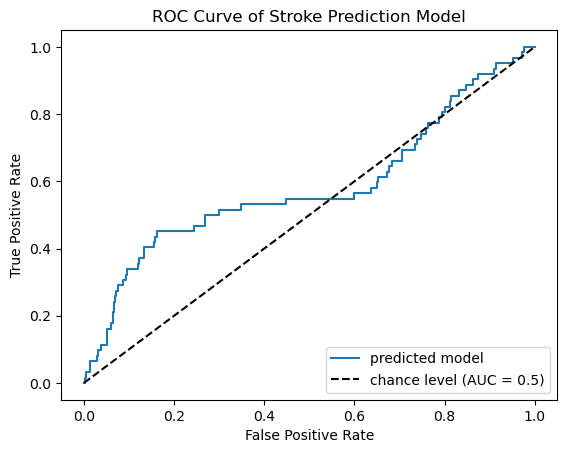

AUC score: 0.5834005376344086


In [115]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [116]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)

In [117]:
# populate result arrays
name.append('SVM')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))
Fb_score.append(fbeta_score(y_test, np.round(y_test_proba[:,1]), beta=1.5))

The same thing happened again: all 62 stroke events were predicted to be non-strokes. This is a problem and a useless model for our goal. We will keep trying to find another model that can distinguish the two classes.

#### 2c. Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
# create grid search and fit model
params = {'penalty':['none', 'l1', 'l2'], 'C':[0.1, 1, 10, 100, 1000]}
logr = LogisticRegression(random_state=42)
logr_cv = GridSearchCV(logr, params, scoring='recall', cv=5)
logr_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'penalty': ['none', 'l1', 'l2']},
             scoring='recall')

In [26]:
# print best parameters
print("Best Parameters: " + str(logr_cv.best_params_))

Best Parameters: {'C': 0.1, 'penalty': 'none'}


In [118]:
# create model with best parameters
logr = LogisticRegression(C=0.1, penalty='none', random_state=42)
logr.fit(X_train, y_train)
y_train_pred = logr.predict(X_train)
y_test_proba = logr.predict_proba(X_test)

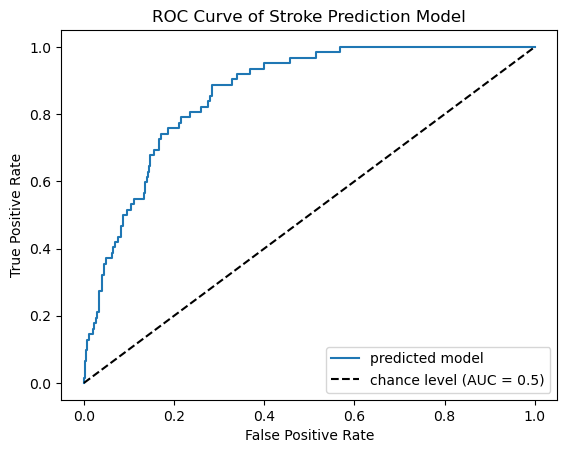

AUC score: 0.8640120967741935


In [119]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [120]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)

In [121]:
# populate result arrays
name.append('LogisticRegression')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))
Fb_score.append(fbeta_score(y_test, np.round(y_test_proba[:,1]), beta=1.5))

Again, all predictions were in the non-stroke class. We need to keep searching.

#### 2d. XGBoost

In [31]:
#! pip install xgboost

In [32]:
from xgboost import XGBClassifier

In [33]:
# train general XGBoost classifier
params = {'n_estimators': [1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 5, 10, 15, 20],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3, 1],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 1],
    'reg_lambda': [0, 0.1, 0.2, 0.3, 1],
    'objective': ["reg:squarederror"],
    'eval_metric': ['mae']}
xgb_model = XGBClassifier(random_state=42)
xgb_cv = RandomizedSearchCV(xgb_model, params, scoring='recall', cv=5)
xgb_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9],
                  

In [34]:
# print best parameters
print("Best Parameters: " + str(xgb_cv.best_params_))

Best Parameters: {'subsample': 0.5, 'reg_lambda': 0.3, 'reg_alpha': 0.2, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'min_child_weight': 15, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'eval_metric': 'mae', 'colsample_bytree': 0.9}


In [122]:
# create model with best parameters
xgb_model = XGBClassifier(subsample= 0.5, reg_lambda= 0.3, reg_alpha= 0.2, objective= 'reg:squarederror', 
                          n_estimators= 1000, min_child_weight= 15, max_depth= 7, learning_rate= 0.1, gamma= 0, 
                          eval_metric= 'mae', colsample_bytree= 0.9, random_state=42)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_test_proba = xgb_model.predict_proba(X_test)

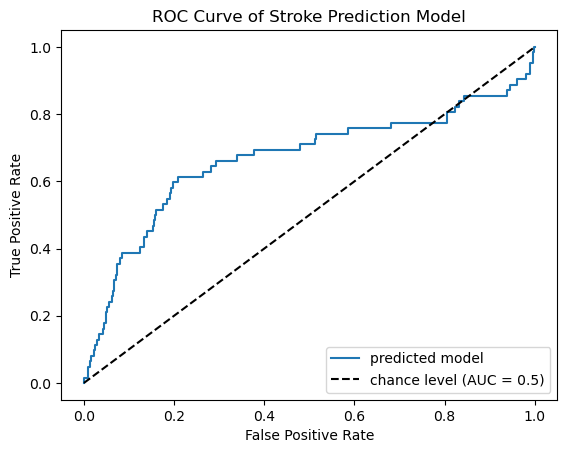

AUC score: 0.6674899193548387


In [123]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [124]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[945,  15],
       [ 58,   4]], dtype=int64)

In [125]:
# populate result arrays
name.append('XGBoost')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))
Fb_score.append(fbeta_score(y_test, np.round(y_test_proba[:,1]), beta=1.5))

This model predicted 2 stroke victims correctly. This is better than a recall of zero but needs much improvement to be a sensible model.

#### 2e. CatBoost

In [39]:
#! pip install catboost

In [40]:
from catboost import CatBoostClassifier

In [41]:
# create grid search and fit model
params = {'depth':[4,6,8,10], 'learning_rate':[0.01, 0.05, 0.1], 'iterations':[10, 50, 100]}
cbc = CatBoostClassifier(random_state=42)
cbc_cv = GridSearchCV(cbc, params, scoring='recall', cv=5)
cbc_cv.fit(X_train,y_train, silent=True)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000022400358220>,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [10, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='recall')

In [42]:
# print best parameters
print("Best Parameters: " + str(cbc_cv.best_params_))

Best Parameters: {'depth': 4, 'iterations': 10, 'learning_rate': 0.01}


In [126]:
# create model with best parameters
cbc = CatBoostClassifier(depth=4, iterations=10, learning_rate=0.01, random_state=42)
cbc.fit(X_train, y_train, silent=True)
y_train_pred = cbc.predict(X_train)
y_test_proba = cbc.predict_proba(X_test)

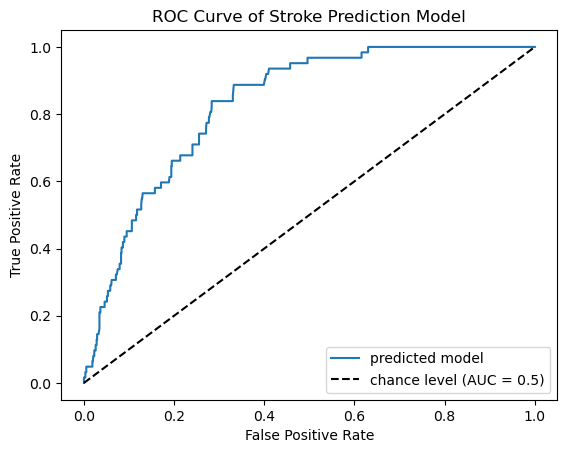

AUC score: 0.8299647177419355


In [127]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [128]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)

In [129]:
# populate result arrays
name.append('CatBoost')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))
Fb_score.append(fbeta_score(y_test, np.round(y_test_proba[:,1]), beta=1.5))

Another model with zero recall. The high class imbalance is proving to be a problem for the algorithms.

### 3. Refine Models with Balanced Data

Given the poor recall and accuracy results of the models above, we will resample the data to remove the class imbalance from the stroke training data. We will use SMOTE to resample the data.

In [47]:
from imblearn.over_sampling import SMOTE

In [130]:
# Upsample to reduce class imbalance
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [131]:
# Check class imbalance and data size
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 187
Before OverSampling, counts of label '0': 3899 

After OverSampling, the shape of X_train: (7798, 17)
After OverSampling, the shape of y_train: (7798,) 

After OverSampling, counts of label '1': 3899
After OverSampling, counts of label '0': 3899


We were able to upsample the training set to remove the stroke class imbalance from the data. The original training data has shape <code> X_train shape: (4086, 17) </code> and the upsampled data has a shape of <code> X_train_res shape: (7798, 17) </code>. The testing set is not affected by this change, we want to keep the integrity of the testing set intact.

Now, we will re-train (and parameter test) all of the models again to see if there are any performance improvements.

#### 3a. Random Forest Classifier

In [50]:
# create grid search and fit model
params = {'n_estimators':[50, 100, 200, 300,1000], 'max_depth':[3,7,20], 'min_samples_split':[2,4,10]}
rfc = RandomForestClassifier(random_state=42)
rfc_cv = GridSearchCV(rfc, params, scoring='recall', cv=5)
rfc_cv.fit(X_train_res,y_train_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 7, 20],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [50, 100, 200, 300, 1000]},
             scoring='recall')

In [51]:
# print best parameters
print("Best Parameters: " + str(rfc_cv.best_params_))

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}


In [132]:
# create model with best parameters
rfc = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=300, random_state=42)
rfc.fit(X_train_res, y_train_res)
y_train_pred = rfc.predict(X_train_res)
y_test_proba = rfc.predict_proba(X_test)

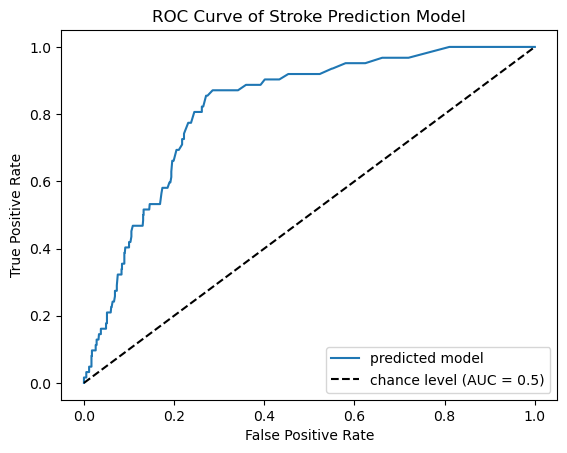

AUC score: 0.8188928091397849


In [133]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [134]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[944,  16],
       [ 57,   5]], dtype=int64)

In [135]:
# populate result arrays
name.append('RandomForest_scaled')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))
Fb_score.append(fbeta_score(y_test, np.round(y_test_proba[:,1]), beta=1.5))

We found a slight improvement in classification results after upsampling the data. Here, with the random forest model, we correctly classified 5 strokes and miss-classified 11 strokes. These are not great results, however, an improvement from the previous models.

#### 3b. Support Vector Machine

In [56]:
# create grid search and fit model
params = {'C':[0.1, 1, 10, 100, 1000], 'gamma':['auto'], 'kernel':['rbf']}
svc = SVC(random_state=42)
svc_cv = GridSearchCV(svc, params, scoring='recall', cv=5)
svc_cv.fit(X_train_res,y_train_res)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': ['auto'],
                         'kernel': ['rbf']},
             scoring='recall')

In [57]:
# print best parameters
print("Best Parameters: " + str(svc_cv.best_params_))

Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [136]:
# create model with best parameters
svc = SVC(C=10, gamma='auto', kernel='rbf', probability=True, random_state=42)
svc.fit(X_train_res, y_train_res)
y_train_pred = svc.predict(X_train_res)
y_test_proba = svc.predict_proba(X_test)

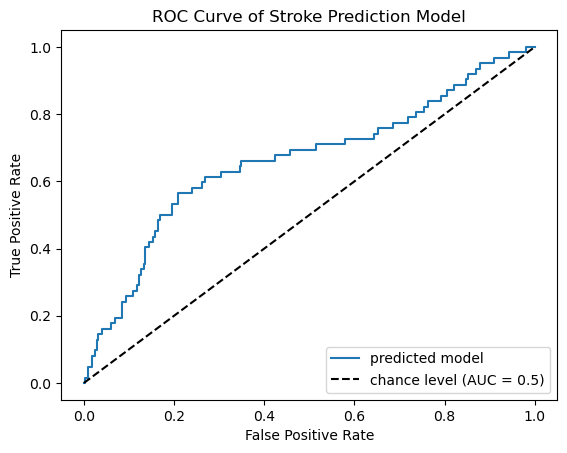

AUC score: 0.6617439516129032


In [137]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [138]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[933,  27],
       [ 54,   8]], dtype=int64)

In [139]:
# populate result arrays
name.append('SVM_scaled')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))
Fb_score.append(fbeta_score(y_test, np.round(y_test_proba[:,1]), beta=1.5))

Again, we found an improvement over the SVM model using the unscaled data. 

#### 3c. Logistic Regression

In [62]:
# create grid search and fit model
params = {'penalty':['none', 'l1', 'l2'], 'C':[0.1, 1, 10, 100, 1000]}
logr = LogisticRegression(random_state=42)
logr_cv = GridSearchCV(logr, params, scoring='recall', cv=5)
logr_cv.fit(X_train_res,y_train_res)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'penalty': ['none', 'l1', 'l2']},
             scoring='recall')

In [63]:
# print best parameters
print("Best Parameters: " + str(logr_cv.best_params_))

Best Parameters: {'C': 0.1, 'penalty': 'l2'}


In [140]:
# create model with best parameters
logr = LogisticRegression(C=0.1, penalty='l2', random_state=42)
logr.fit(X_train_res, y_train_res)
y_train_pred = logr.predict(X_train_res)
y_test_proba = logr.predict_proba(X_test)

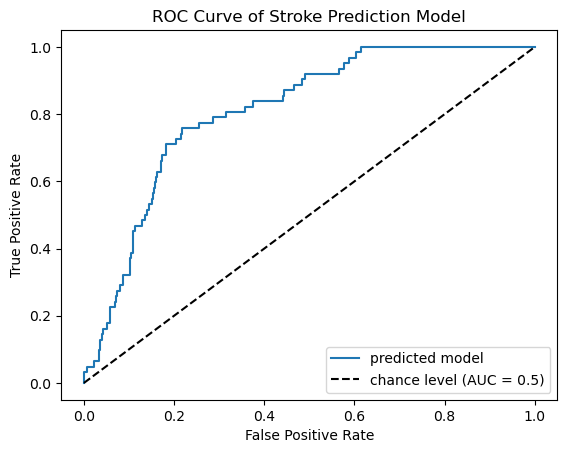

AUC score: 0.8103326612903227


In [141]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [142]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[897,  63],
       [ 48,  14]], dtype=int64)

In [143]:
# populate result arrays
name.append('LogisticRegression_scaled')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))
Fb_score.append(fbeta_score(y_test, np.round(y_test_proba[:,1]), beta=1.5))

#### 3d. XGBoost Classifier

In [68]:
# train general XGBoost classifier
params = {'n_estimators': [1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 5, 10, 15, 20],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3, 1],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 1],
    'reg_lambda': [0, 0.1, 0.2, 0.3, 1],
    'objective': ["reg:squarederror"],
    'eval_metric': ['mae']}
xgb_model = XGBClassifier(random_state=42)
xgb_cv = RandomizedSearchCV(xgb_model, params, scoring='recall', cv=5)
xgb_cv.fit(X_train_res,y_train_res)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9],
                  

In [69]:
# print best parameters
print("Best Parameters: " + str(xgb_cv.best_params_))

Best Parameters: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0.3, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'eval_metric': 'mae', 'colsample_bytree': 0.5}


In [144]:
# create model with best parameters
xgb_model = XGBClassifier(subsample= 0.9, reg_lambda= 0.1, reg_alpha= 0.3, objective= 'reg:squarederror', 
                          n_estimators= 1000, min_child_weight= 10, max_depth= 7, learning_rate= 0.1, gamma= 0, 
                          eval_metric= 'mae', colsample_bytree= 0.5, random_state=42)
xgb_model.fit(X_train_res, y_train_res)
y_train_pred = xgb_model.predict(X_train_res)
y_test_proba = xgb_model.predict_proba(X_test)

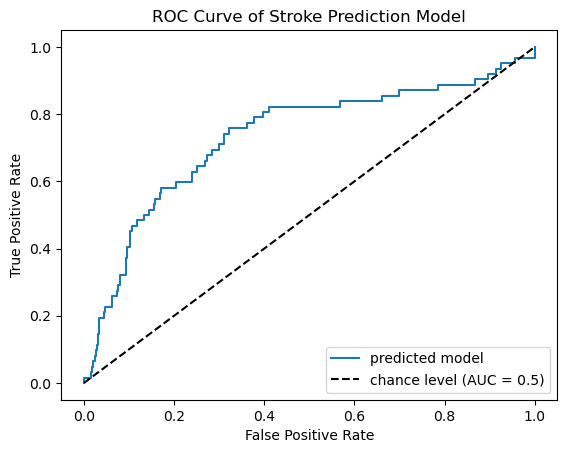

AUC score: 0.7327452956989248


In [145]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [146]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[944,  16],
       [ 61,   1]], dtype=int64)

In [147]:
# populate result arrays
name.append('XGBoost_scaled')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))
Fb_score.append(fbeta_score(y_test, np.round(y_test_proba[:,1]), beta=1.5))

#### 3e. CatBoost Classifier

In [74]:
# create grid search and fit model
params = {'depth':[4,6,8,10], 'learning_rate':[0.01, 0.05, 0.1], 'iterations':[10, 50, 100]}
cbc = CatBoostClassifier(random_state=42)
cbc_cv = GridSearchCV(cbc, params, scoring='recall', cv=5)
cbc_cv.fit(X_train_res,y_train_res, silent=True)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002240073E280>,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [10, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='recall')

In [75]:
# print best parameters
print("Best Parameters: " + str(cbc_cv.best_params_))

Best Parameters: {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}


In [148]:
# create model with best parameters
cbc_model = CatBoostClassifier(depth=10, iterations=100, learning_rate=0.1, random_state=42)
cbc_model.fit(X_train_res, y_train_res, silent=True)
y_train_pred = cbc_model.predict(X_train_res)
y_test_proba = cbc_model.predict_proba(X_test)

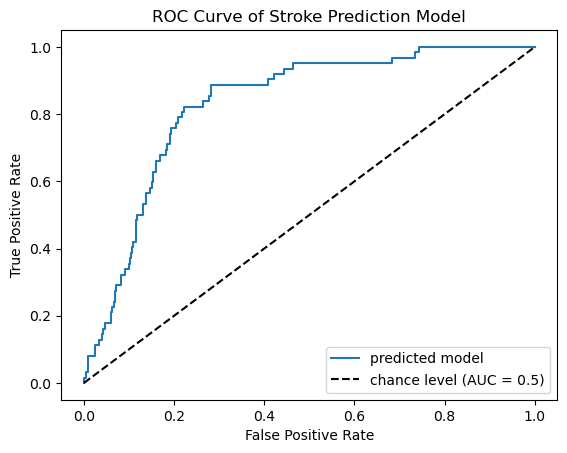

AUC score: 0.8310483870967743


In [149]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [150]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[930,  30],
       [ 55,   7]], dtype=int64)

In [151]:
# populate result arrays
name.append('CatBoost_scaled')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))
Fb_score.append(fbeta_score(y_test, np.round(y_test_proba[:,1]), beta=1.5))

### 4. Discussion and Conclusion

We found improved results training the models with upsampled training data. Unlike the initial models, the upsampled models were able to make some correct stroke predictions. A collection of the models, their AUC, F1-score, and F1.5-score can be shown below. Here, we include the F1.5-score to emphasize a greater weight on the recall rather than the precision. In healthcare contexts such as these, the recall is a more important metric given that we want to minimize predicting 0 (non-stroke) when the patient is actually a stroke victim. 

In [152]:
# results array
results_df = pd.DataFrame({'Model Name':name, 'AUC':AUC, 'F1 Score':F1_score, 'F1.5 Score':Fb_score})
results_df.to_csv('Results_df.csv')
results_df

,Model Name,AUC,F1 Score,F1.5 Score
0,RandomForest,0.823824,0.000000,0.000000
1,SVM,0.583401,0.000000,0.000000
2,LogisticRegression,0.864012,0.000000,0.000000
3,XGBoost,0.667490,0.098765,0.082019
4,CatBoost,0.829965,0.000000,0.000000
5,RandomForest_scaled,0.818893,0.120482,0.101246
6,SVM_scaled,0.661744,0.164948,0.148997
7,LogisticRegression_scaled,0.810333,0.201439,0.210162
8,XGBoost_scaled,0.732745,0.025316,0.020767
9,CatBoost_scaled,0.831048,0.141414,0.128895


Again, all of the best models are using the upsampled training data. The testing perfomance can be found in the <code>results_df</code> table. Arguably, the best models, in this order, are LogisticRegression_scaled, SVM_scaled, and CatBoost_scaled. Next, let's look at their feature importances to get some insight on what features in the data are most important at predicting strokes.

#### Feature Importances

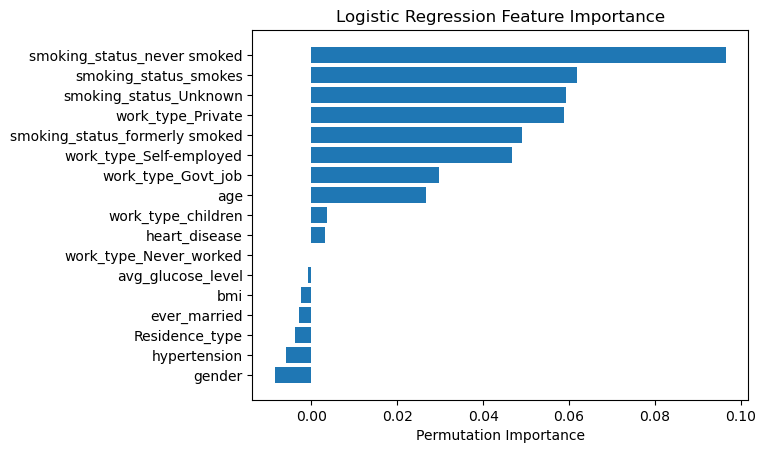

Top 5 features: ['smoking_status_never smoked' 'smoking_status_smokes'
 'smoking_status_Unknown' 'work_type_Private'
 'smoking_status_formerly smoked']


In [153]:
# find feature importance of LogisticRegression model
perm_importance = permutation_importance(logr, X_test, y_test)
feature_names = np.array(X_test.columns)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Permutation Importance")
plt.show()

print("Top 5 features: " + str(feature_names[np.flip(sorted_idx)][:5]))

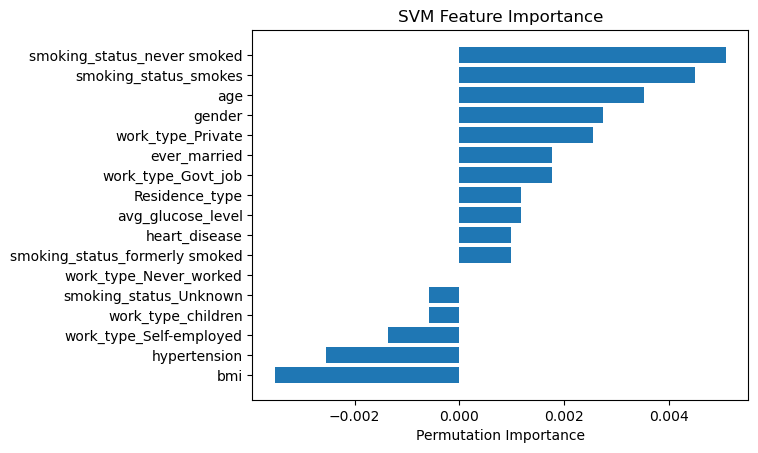

Top 5 features: ['smoking_status_never smoked' 'smoking_status_smokes' 'age' 'gender'
 'work_type_Private']


In [81]:
# find feature importance of SVM model
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(svc, X_test, y_test)
feature_names = np.array(X_test.columns)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("SVM Feature Importance")
plt.xlabel("Permutation Importance")
plt.show()

print("Top 5 features: " + str(feature_names[np.flip(sorted_idx)][:5]))

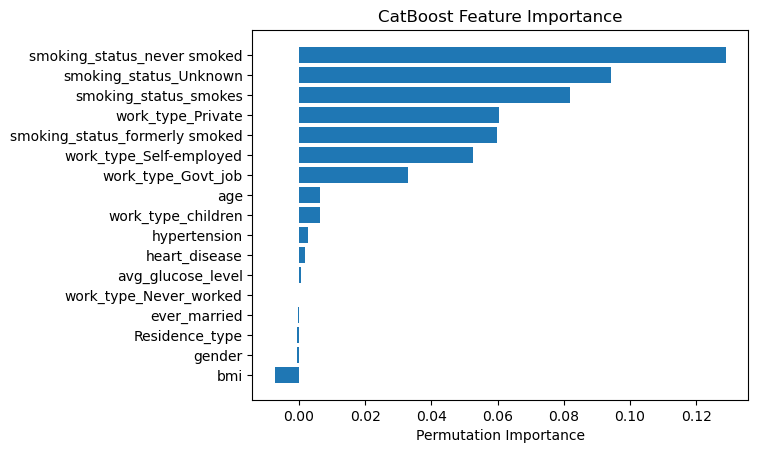

Top 5 features: ['smoking_status_never smoked' 'smoking_status_Unknown'
 'smoking_status_smokes' 'work_type_Private'
 'smoking_status_formerly smoked']


In [154]:
# find feature importance of CatBoost model
perm_importance = permutation_importance(cbc_model, X_test, y_test)
feature_names = np.array(X_test.columns)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("CatBoost Feature Importance")
plt.xlabel("Permutation Importance")
plt.show()

print("Top 5 features: " + str(feature_names[np.flip(sorted_idx)][:5]))

The feature importance analysis highlighted some interesting information. The top features for multiple models were <code>smoking_status_never smoked</code>, <code>smoking_status_smokes</code>, <code>smoking_status_formerly smoked</code>, <code>smoking_status_Unknown</code>, <code>age</code>, and interestingly enough, <code>work_type_Private</code>. Moreover, our models are strongly hinting that there are correlations between smoking status and strokes. Also, there may be also a correlation between strokes and working in the private sector. Also, there appears to be correlations between age and strokes, which makes sense.

Let's visualize these relationships further.

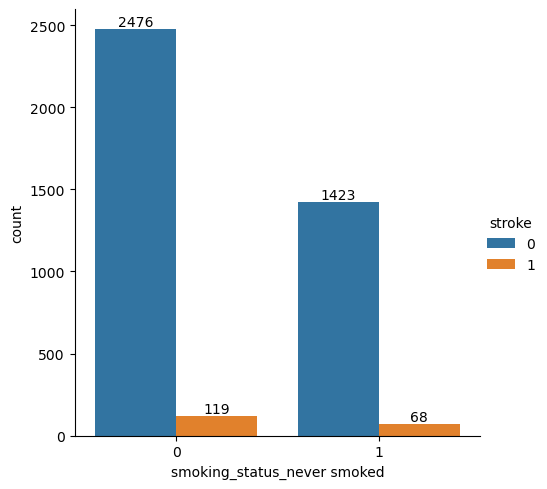

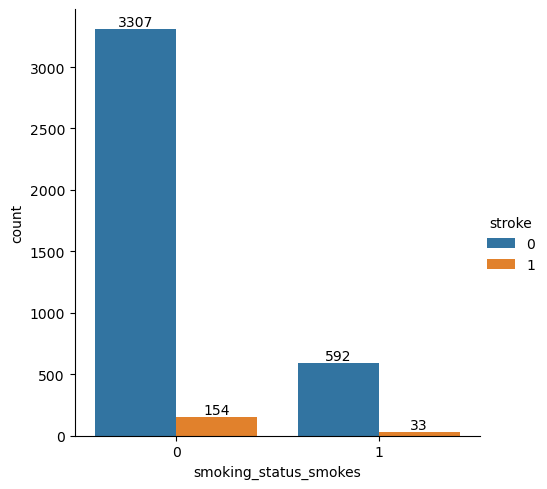

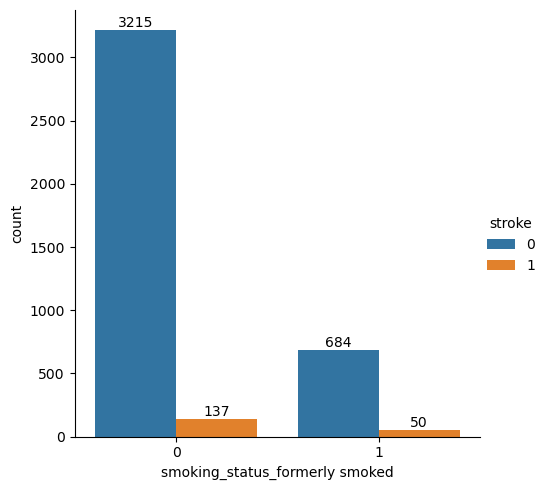

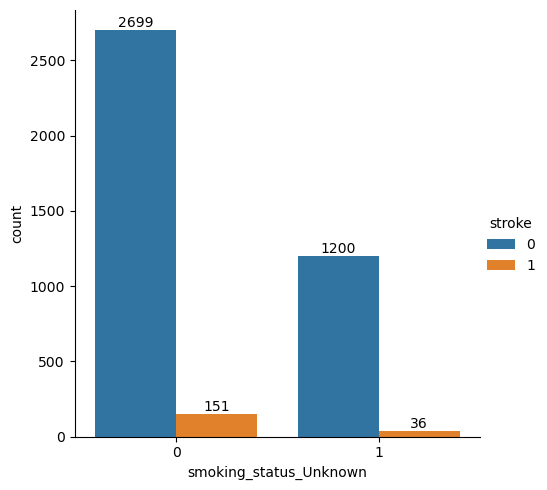

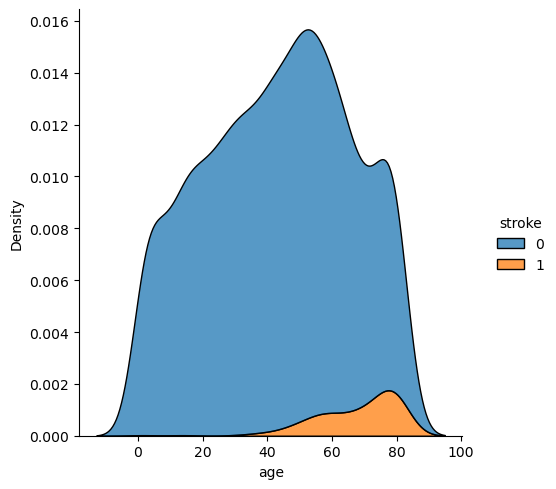

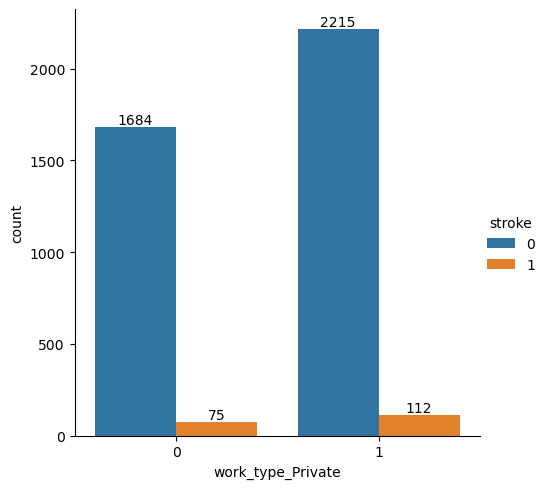

In [158]:
full_data = X_train
full_data['stroke'] = y_train
full_data.head()

g=sns.catplot(data=full_data, x='smoking_status_never smoked', hue='stroke', kind='count')
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0]) 
    ax.bar_label(ax.containers[1])
    
g=sns.catplot(data=full_data, x='smoking_status_smokes', hue='stroke', kind='count')
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0]) 
    ax.bar_label(ax.containers[1])
    
g=sns.catplot(data=full_data, x='smoking_status_formerly smoked', hue='stroke', kind='count')
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0]) 
    ax.bar_label(ax.containers[1])
    
g=sns.catplot(data=full_data, x='smoking_status_Unknown', hue='stroke', kind='count')
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0]) 
    ax.bar_label(ax.containers[1])
    
g=sns.displot(data=full_data, x='age', hue='stroke', kind='kde', multiple='stack')
#for ax in g.axes.flat:
#    ax.bar_label(ax.containers[0]) 
#    ax.bar_label(ax.containers[1])
    
g=sns.catplot(data=full_data, x='work_type_Private', hue='stroke', kind='count')
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0]) 
    ax.bar_label(ax.containers[1])

In [159]:
# create new column of sum of top features (excluding doesn't smoke)
full_data['Any_top_5'] = full_data['smoking_status_smokes'] + full_data['smoking_status_formerly smoked'] + \
            full_data['smoking_status_Unknown'] + full_data['work_type_Private']
full_data['Any_top_5'].describe()

count    4086.000000
mean        1.204601
std         0.651700
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: Any_top_5, dtype: float64

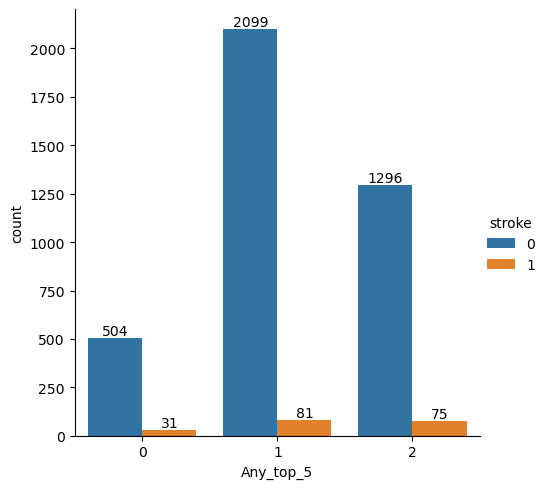

In [160]:
# plot the sum column
g = sns.catplot(data=full_data, x='Any_top_5', hue='stroke', kind='count')
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0]) 
    ax.bar_label(ax.containers[1])

In [173]:
# create new column of boolean if over 40 and generate new sum column
full_data['over40'] = full_data['age'] > 40
full_data['over40'] = full_data['over40'] * 1

full_data['Any_top_6'] = full_data['smoking_status_smokes'] + full_data['smoking_status_formerly smoked'] + \
            full_data['smoking_status_Unknown'] + full_data['work_type_Private'] + full_data['over40']
full_data['Any_top_6'].describe()

count    4086.000000
mean        1.763093
std         0.821181
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: Any_top_6, dtype: float64

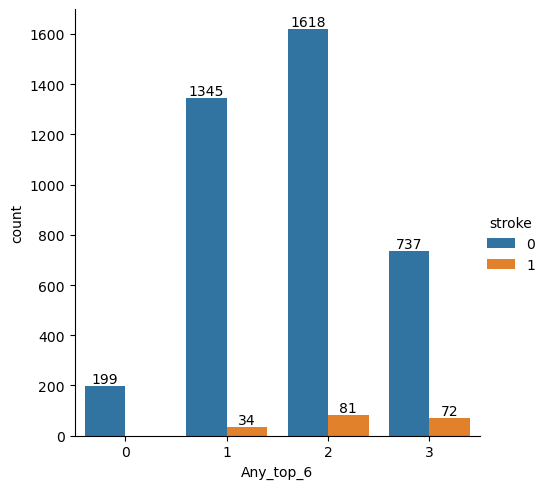

In [174]:
# plot the sum column including the age boolean
g = sns.catplot(data=full_data, x='Any_top_6', hue='stroke', kind='count')
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0]) 
    ax.bar_label(ax.containers[1])

These plots show us some further information on the correlations between the top features and stroke status. Interestingly enough, <code>smoking_status_never smoked</code> has a higher proportion of strokes than both <code>smoking_status_smokes</code> and <code>smoking_status_formerly smoked</code>. I expected the smokers to have a higher proportion of strokes but the data tells a different story. Also, the only category of the top features that has a higher proportion of stroke victims in the positive class is <code>work_type_Private</code>. This means that the data suggests that individuals who work in the private sector have a higher chance of having a stroke. This fact could be due to chance and other missing key features of data, or this discovery could have merit. Lastly, we look at the distribution of <code>age</code> which shows almost all strokes happening over 40 years old with the maximum around 75-80 years old. 

We created an additional feature consisting of the sum of all smoking features and the private work feature, excluding the non-smoking feature and age. This feature will show us if there's a combination of both currently smoking and working privately or formerly smoking and working privately etc. and its relationship with stroke status. This plot shows that having a value of 1 or 2, meaning that it has at least one of these attributes, tends to increase the likelihood of having a stroke. We created a similar plot with the addition of age as well. First, we generated a boolean whether the patient is over 40 years old, and then we summed the features as we did before. This plot did an even better job at separating the stroke classes as seen above. 

#### Hypothesis Test for Private Work and Stroke Status

To test whether there is any merit in our discovery, we will perform a quick hypothesis test to determine if there is any statistical significance between working in the private sector and stroke status. Because we have a relatively small sample size and two classes, we will be using a two-sample t-test. 

null hypothesis: there is no difference in stroke status for patients who work in the private sector

alternative hypothesis: patients who work in the private sector have higher stroke rates than patients who work in other sectors.

In [87]:
# split the data
Private_stroke = full_data[full_data['stroke']==1]['work_type_Private']
Private_nonStroke = full_data[full_data['stroke']==0]['work_type_Private']

In [88]:
# define the t-distribution
from scipy.stats import t, ttest_ind
rv = t(df=100-2)

In [89]:
# two sampled t-test
t_stat, pvalue = ttest_ind(Private_stroke, Private_nonStroke)
print('t-statistic: ' + str(t_stat), 'p-value: ' + str(pvalue))

t-statistic: 0.8317740703116947 p-value: 0.4055851126120038


Although there appears to be some correlation between stroke status and working in the private sector, it is not statistically significant enough to reject the null hypothesis because the p-value is greater than 0.05.

#### Classification Threshold Tuning

An additional parameter that needs to be tested is the threshold for classification. Furthermore, each of these model's output is a set of probabilities for the testing class and up to this point, we have been using a 50% (0.5) threshold to convert these probabilities into a binary array. However, with the class imbalance present in the data, this threshold may not be suitable. We are going to test this with the top 3 models and re-evaluate the F1-score, F1.5-score, and confusion matrices.

In [175]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int');

In [176]:
# threshold tuning for SVM

y_test_proba = svc.predict_proba(X_test)

# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
f1_scores = [f1_score(y_test, to_labels(y_test_proba[:,1], t)) for t in thresholds]
fb_scores = [fbeta_score(y_test, to_labels(y_test_proba[:,1], t), beta=1.5) for t in thresholds]
# get best threshold
ix_f1 = np.argmax(f1_scores)
ix_fb = np.argmax(fb_scores)
print('F1-Score=%.5f, Threshold=%.3f' % (f1_scores[ix_f1], thresholds[ix_f1]))
print('F1.5-Score=%.5f, Threshold=%.3f' % (fb_scores[ix_fb], thresholds[ix_fb]))

F1-Score=0.24314, Threshold=0.010
F1.5-Score=0.30301, Threshold=0.010


In [177]:
# save results to arrays
score_f1 = []
score_fb = []
thresh_f1 = []
thresh_fb = []
AUC_f1 = []
AUC_fb = []
name = []

# append data
score_f1.append(f1_scores[ix_f1])
score_fb.append(fb_scores[ix_fb])
thresh_f1.append(thresholds[ix_f1])
thresh_fb.append(thresholds[ix_fb])
AUC_f1.append(roc_auc_score(y_test, to_labels(y_test_proba[:,1], thresholds[ix_f1])))
AUC_fb.append(roc_auc_score(y_test, to_labels(y_test_proba[:,1], thresholds[ix_fb])))
name.append('SVM')

In [178]:
# print confusion matrix for optimal threshold
labels = to_labels(y_test_proba[:,1], thresholds[ix_f1])
print("F1-score confusion matrix:")
print(confusion_matrix(y_test, labels))

labels = to_labels(y_test_proba[:,1], thresholds[ix_fb])
print("F1.5-score confusion matrix:")
print(confusion_matrix(y_test, labels))

F1-score confusion matrix:
[[798 162]
 [ 31  31]]
F1.5-score confusion matrix:
[[798 162]
 [ 31  31]]


In [179]:
# threshold tuning for Logistic Regression

y_test_proba = logr.predict_proba(X_test)

# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
f1_scores = [f1_score(y_test, to_labels(y_test_proba[:,1], t)) for t in thresholds]
fb_scores = [fbeta_score(y_test, to_labels(y_test_proba[:,1], t), beta=1.5) for t in thresholds]
# get best threshold
ix_f1 = np.argmax(f1_scores)
ix_fb = np.argmax(fb_scores)
print('F1-Score=%.5f, Threshold=%.3f' % (f1_scores[ix_f1], thresholds[ix_f1]))
print('F1.5-Score=%.5f, Threshold=%.3f' % (fb_scores[ix_fb], thresholds[ix_fb]))

F1-Score=0.31317, Threshold=0.266
F1.5-Score=0.39888, Threshold=0.266


In [180]:
# append data
score_f1.append(f1_scores[ix_f1])
score_fb.append(fb_scores[ix_fb])
thresh_f1.append(thresholds[ix_f1])
thresh_fb.append(thresholds[ix_fb])
AUC_f1.append(roc_auc_score(y_test, to_labels(y_test_proba[:,1], thresholds[ix_f1])))
AUC_fb.append(roc_auc_score(y_test, to_labels(y_test_proba[:,1], thresholds[ix_fb])))
name.append('Logistic Regression')

In [181]:
# print confusion matrix for optimal threshold
labels = to_labels(y_test_proba[:,1], thresholds[ix_f1])
print("F1-score confusion matrix:")
print(confusion_matrix(y_test, labels))

labels = to_labels(y_test_proba[:,1], thresholds[ix_fb])
print("F1.5-score confusion matrix:")
print(confusion_matrix(y_test, labels))

F1-score confusion matrix:
[[785 175]
 [ 18  44]]
F1.5-score confusion matrix:
[[785 175]
 [ 18  44]]


In [182]:
# threshold tuning for CatBoost

y_test_proba = cbc_model.predict_proba(X_test)

# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
f1_scores = [f1_score(y_test, to_labels(y_test_proba[:,1], t)) for t in thresholds]
fb_scores = [fbeta_score(y_test, to_labels(y_test_proba[:,1], t), beta=1.5) for t in thresholds]
# get best threshold
ix_f1 = np.argmax(f1_scores)
ix_fb = np.argmax(fb_scores)
print('F1-Score=%.5f, Threshold=%.3f' % (f1_scores[ix_f1], thresholds[ix_f1]))
print('F1.5-Score=%.5f, Threshold=%.3f' % (fb_scores[ix_fb], thresholds[ix_fb]))

F1-Score=0.31973, Threshold=0.138
F1.5-Score=0.41180, Threshold=0.122


In [183]:
# append data
score_f1.append(f1_scores[ix_f1])
score_fb.append(fb_scores[ix_fb])
thresh_f1.append(thresholds[ix_f1])
thresh_fb.append(thresholds[ix_fb])
AUC_f1.append(roc_auc_score(y_test, to_labels(y_test_proba[:,1], thresholds[ix_f1])))
AUC_fb.append(roc_auc_score(y_test, to_labels(y_test_proba[:,1], thresholds[ix_fb])))
name.append('CatBoost')

In [184]:
# print confusion matrix for optimal threshold
labels = to_labels(y_test_proba[:,1], thresholds[ix_f1])
print("F1-score confusion matrix:")
print(confusion_matrix(y_test, labels))

labels = to_labels(y_test_proba[:,1], thresholds[ix_fb])
print("F1.5-score confusion matrix:")
print(confusion_matrix(y_test, labels))

F1-score confusion matrix:
[[775 185]
 [ 15  47]]
F1.5-score confusion matrix:
[[748 212]
 [ 11  51]]


In [185]:
thresh_df = pd.DataFrame({'Model':name, 'F1-Score':score_f1, 'F1.5-Score':score_fb, 'AUC (w/ F1 Threshold)':AUC_f1, \
                          'AUC (w/ F1.5 Threshold)':AUC_fb, 'F1 Threshold':thresh_f1, 'F1.5 Threshold': thresh_fb})
thresh_df

,Model,F1-Score,F1.5-Score,AUC (w/ F1 Threshold),AUC (w/ F1.5 Threshold),F1 Threshold,F1.5 Threshold
0,SVM,0.243137,0.303008,0.665625,0.665625,0.010,0.010
1,Logistic Regression,0.313167,0.398884,0.763693,0.763693,0.266,0.266
2,CatBoost,0.319728,0.411801,0.782678,0.800874,0.138,0.122


From this threshold analysis for our top models, we have determined that 0.5 is not an optimal threshold to optimize neither the F1-score or the F1.5-score. The table above shows the "optimal" collection of results. In fact, this analysis showed that a CatBoost model may be the best option for this data. Nonetheless, threshold tuning is very important to these models for this dataset and needs to be done to improve the performance. 

#### Conclusion

In this work, we have trained and tested five classification models to try to best predict strokes in patients: random forest classifier, support vector machine, logistic regression classifier, XGBoost classifier, and CatBoost classifier. We performed a parameter search on all algorithms to optimize the parameters used in each scenario. The original data contains a class-imbalance in the stroke status where strokes are outweighed 249:4860 or almost 1:20. This class imbalance causes many issues for the algorithms and makes the correct classifications hard to achieve. For the original models, we did not alter the data and trained/tested on the data in its original form. To assess the performance of the models, we recorded the area under the curve (AUC), the F1-score, and the F1.5-score. The F1.5-score was recorded because it places a higher emphasis on the recall rather than the precision. The recall is more important in data like this because it is important that we minimize the false-negative predictions. Furthermore, false-negative predictions in this scenario are patients who have a stroke status of 1 but we predict them as 0. This scenario is also referred to as a Type II error and can be detrimental in health-related instances. 

None of the baseline models (models using unaltered data) performed well in their testing classifications. All of the models except the XGBoost algorithm, predicted all observations as non-stroke. In a class-imbalanced environment, this classification may achieve high accuracy; however, a recall of zero and basically useless to the project. The XGBoost algorithm predicted only 1 stroke correctly, which is only a marginal improvement.

Given the poor performance and high class imbalance of the baseline models, we upsampled the training data to remove the class-imbalance in the data and re-trained our models. Removing the imbalance from the data improved all five models. In fact, the recall is greater than zero for all models. We selected Logistic Regression, SVM, and CatBoost as our best models (in that order) by having the maximum F1-score, F1.5-score, and AUC combinations. However, the classification results are still barely better than guessing. The Logistic Regression model, the best of its class, correctly predicted 14 strokes, missed 48 strokes, and misclassified 63 non-strokes as strokes. These results tell us a few things about the data: First, is that predicting a stroke may be quite difficult; Secondly, we may be missing key features that help predict strokes in patients. 

Then, we performed some additional analysis on the top models. First, we wanted to identify the most important features for each model. For all three models, the top features were very similar with only a couple exceptions. The top six that showed up the most were: <code>smoking_status_never smoked</code>, <code>smoking_status_smokes</code>, <code>smoking_status_formerly smoked</code>, <code>smoking_status_Unknown</code>, <code>age</code>, and <code>work_type_Private</code>. Furthermore, we found there were some correlations between smoking status and stroke status and also working in the private sector and stroke status. However, upon further analysis of smoking vs. strokes, the results were not as we may have predicted. The data shows us that non-smokers have a higher proportion of strokes than individuals who currently or formerly smoked. Also, interestingly enough, individuals in the private sector have a higher chance to have a stroke than others. This was the only feature that has a higher proportion of strokes in the positive class than the latter. However, we performed a hypothesis test on this discovery and found the results to be insignificant statistically and were unable to reject the null hypothesis. Lastly, we did some testing on the threshold parameter for classifying the probability predictions from the models. For all of the prior models, this parameter was set as 50% or 0.5, which is the default. But working with imbalanced data may suggest a different threshold value. Therefore, we calculated the optimal threshold for both the F1-score and F1.5-score for each model and re-calculated the metrics. We found that the threshold parameter is indeed important in this analysis and exposed the CatBoost model to be the best. This model correctly predicted 51 strokes, missed 11 strokes, and missclassified 212 non-strokes as strokes.

In future work, this model could be refined with additional observations (more patients) and additional features. Perhaps, there are other features that doctors use today to determine if a patient is at risk for a stroke that would also be useful for our models. Also, additional parameter tuning could be performed as well as applying different algorithms. 